# Galactic Dust

In [1]:
import sys
sys.path.append("~/.local/lib/python3.6/site-packages")
import healpy as hp
import numpy as np
import pylab as pl
import pysm

# Reproduce Planck colormap
from matplotlib.colors import ListedColormap
colombi1_cmap = ListedColormap(np.loadtxt("https://raw.githubusercontent.com/zonca/paperplots/master/data/Planck_Parchment_RGB.txt")/255.)
colombi1_cmap.set_bad("gray") # color of missing pixels
colombi1_cmap.set_under("white") # color of background, necessary if you want to use
cmap = colombi1_cmap

%matplotlib inline

## Measurments of Galactic Dust Foreground
We will start with loading the dust intensity map obtained with the Planck COMMANDER pipeline. More details on how this is obtained can be found [here](https://arxiv.org/abs/1807.06208). The fits file consists of multiple columns. The description of the first seven columns reads
```
TTYPE1  = 'I_ML_FULL '  / Full period Intensity map                      
TTYPE2  = 'I_ML_HM1 '   / Half Mission 1 Intensity map                   
TTYPE3  = 'I_ML_HM2 '   / Half Mission 2 Intensity map                   
TTYPE4  = 'I_ML_HR1 '   / Half Ring 1 Intensity map                      
TTYPE5  = 'I_ML_HR2 '   / Half Ring 2 Intensity map                      
TTYPE6  = 'I_ML_YR1 '   / Year 1 Intensity map                           
TTYPE7  = 'I_ML_YR2 '   / Year 2 Intensity map 
```
For now we will only care about the first column, which contains the map of the full dataset. The maps are given in $\mu K_{RJ}$ units. We will work in $\mu K_{CMB}$ units in the following, therefore we have to convert the units first. More details on what these units mean are [here](https://github.com/bthorne93/PySM_public/blob/master/docs/unit_conversion.pdf). In order to keep memory usage low we will downgrade the resolution of the map to a [HEALPix resolution parameter](https://healpix.jpl.nasa.gov/pdf/intro.pdf) of $N_{side}=256$.

In [21]:
nside=256

dust_map=hp.read_map('data/COM_CompMap_ThermalDust-commander_2048_R2.00.fits',0)

cst = 56.8
nu = 545. # The reference frequency in GHz
CMBtoRJ=(nu/cst)**2*np.exp(nu/cst)/(np.exp(nu/cst)-1)**2

dust_map*=1./CMBtoRJ

dust_map=hp.ud_grade(dust_map,nside)

Next we will compare it visually to the Planck HFI 353 GHz map. We see that the structure looks similar, but the absolute values values seem off. This is because thermal dust emission is brighter at 545 GHz (the reference frequency the COMMANDER dust map is given in) than 353 GHz. The brightness of dust follows a so called modified black-body spectrum, which you can see in the red band in the image below (along with several other foreground components, find more [here](https://arxiv.org/pdf/1502.01588.pdf)). 
<img src="https://www.cosmos.esa.int/documents/387566/425793/2015_FGSpectra/310c443d-9c44-433e-843a-61363a62f9da?t=1423091990056" width="500" />
We will deal with this frequency scaling later on in the notebook. 

You can also go ahead and try to compare the Q and U maps at 353 GHz with the dust intensity.

In [58]:
f100_map=hp.read_map('data/HFI_SkyMap_100_2048_R4.00_full.fits',[0,1,2])
f100_map[0]=hp.remove_dipole(f100_map[0],gal_cut=30) # necessary for visualizing this specific map, but details are irrelevant now

f100_map=hp.ud_grade(f100_map,nside)
f100_map*=1e6 # These maps are given in K_{CMB}

f353_map=hp.read_map('data/HFI_SkyMap_353_2048_R4.00_full.fits',[0,1,2])
f353_map[0]=hp.remove_dipole(f353_map[0],gal_cut=30) # necessary for visualizing this specific map, but details are irrelevant now

f353_map=hp.ud_grade(f353_map,nside)
f353_map*=1e6 # These maps are given in K_{CMB}

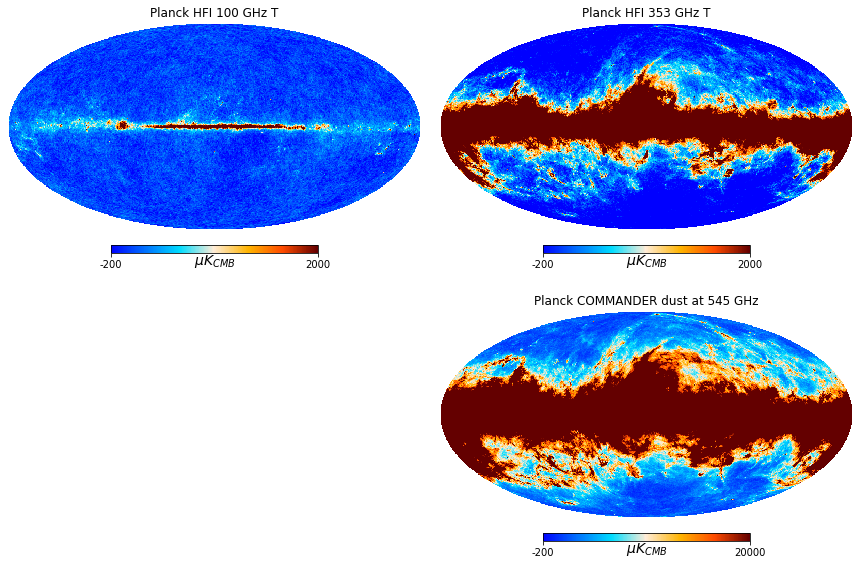

In [59]:
pl.figure(figsize=(12,8))

hp.mollview(f100_map[0],title='Planck HFI 100 GHz T',  cmap=cmap, unit=r'$\mu K_{CMB}$', min=-200, max=2000, sub=(2,2,1))
hp.mollview(f353_map[0],title='Planck HFI 353 GHz T',  cmap=cmap, unit=r'$\mu K_{CMB}$', min=-200, max=2000, sub=(2,2,2))
hp.mollview(dust_map,   title='Planck COMMANDER dust at 545 GHz', cmap=cmap, unit=r'$\mu K_{CMB}$', min=-200, max=20000, sub=(2,2,4))

## Component Separation

To get a rough idea how foreground cleaning works we assume a simple sky model containing the CMB intensity, which is frequency independent, and some intensity of dust depending on the frequency, $\nu$, described by a scalar function $A^\nu$,
$$ I^\nu=I^{CMB}+A^\nu \cdot I^{dust}.$$
Also let's assume that dust is dominating at 353 GHz (which may be true for polarization, but a very crude assumption for intensity)
$$I^{dust}=I^{353\ GHz}.$$
We could then try to get a clean CMB by subtracting out the template
$$I^{CMB}=I^{100\ GHz}-A^{100\ GHz} \cdot I^{dust}$$
once we obtain an estimate of $A^{100\ GHz}$ by a least square minimization of the right hand side of the equation. We will revisit and compare the value we obtain for $A^{100\ GHz}$ later.

The estimate for A^{100 GHz}: 0.037


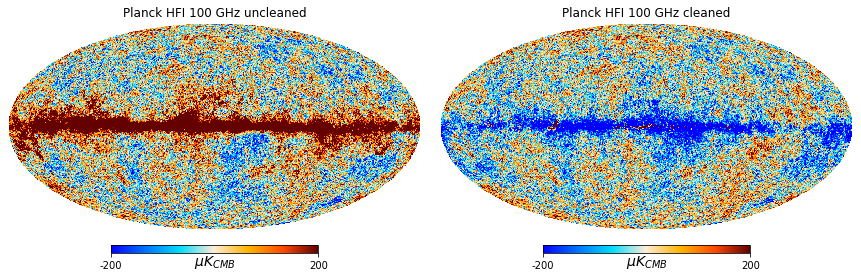

In [97]:
from scipy.optimize import lsq_linear

res=lsq_linear(f353_map[0][:,np.newaxis],f100_map[0])

cmb_map=f100_map[0]-res.x[0]*f353_map[0]
print('The estimate for A^{100 GHz}: %.03f'%res.x[0])

pl.figure(figsize=(12,4))
hp.mollview(f100_map[0],title='Planck HFI 100 GHz uncleaned', cmap=cmap, unit=r'$\mu K_{CMB}$', min=-200, max=200, sub=(1,2,1))
hp.mollview(cmb_map, title='Planck HFI 100 GHz cleaned',   cmap=cmap, unit=r'$\mu K_{CMB}$', min=-200, max=200, sub=(1,2,2))

## Statistical Model for Dust
To model the polarized galactic emission we start from the integral equations for the emission of an optically thin medium [[Planck 2015](https://www.aanda.org/articles/aa/pdf/2015/04/aa24086-14.pdf)]
$$ I(\nu)=\int S(\nu) \left[ 1-p_0\left( \cos^2\gamma -\frac{2}{3} \right) \right] d\tau_\nu $$
$$ Q(\nu)=\int p_0 S(\nu) \cos(2\phi) \cos^2\gamma d\tau_\nu $$
$$ U(\nu)=\int p_0 S(\nu) \sin(2\phi) \cos^2\gamma d\tau_\nu, $$
where $S(\nu)$ is the so-called source function, $\tau_\nu$ is the optical depth, $p_0$ is a parameter describing the dust polarization properties and $\gamma$ and $\phi$ describe the orientation of the galactic magnetic field with respect of the plane of the sky. Those integrals can essentially be seen as integrals along the line-of-sight.

First let's follow [Planck 2016](https://arxiv.org/abs/1604.01029) Eq. 5 and compute the two basis vectors 
$\mathbf{n}$ and $\mathbf{e}$ for each HEALPix pixel, resulting in two $3\times N_{pix}$ arrays.

In [61]:
npix=hp.nside2npix(nside)
r=hp.pix2vec(nside,np.arange(npix))

#North vector n=(rxz)xz (z=[0,0,1]) 
n=r*r[2]*(-1.)
n[2]+=1.
n=n/np.sqrt(np.einsum('sp,sp->p',n,n))

#East vector e=-rxn
e=np.cross(r,n,axisa=0,axisb=0).T*(-1.)
e=e/np.sqrt(np.einsum('sp,sp->p',e,e))

Next we define a function to project a three-dimonsional vector field, $\mathbf{B}$, a $3\times N_{pix}$ array, onto the sphere described by the two angles $\gamma$ and $\phi$ that we introduced earlier (Eq. 6 in [Planck 2016](https://arxiv.org/abs/1604.01029)).

In [62]:
def do_projection(B,Bdims='sp'):
    B=B/np.sqrt(np.einsum('%s,%s->p'%(Bdims,Bdims),B,B))
    Bperp=B-r*np.einsum('%s,sp->p'%Bdims,B,r)
    phi=np.pi-np.sign(np.einsum('sp,sp->p',Bperp,e))*np.arccos(np.einsum('sp,sp->p',Bperp,n)/np.sqrt(np.einsum('sp,sp->p',Bperp,Bperp)))
    cos2gamma=1.-np.abs(np.einsum('%s,sp->p'%Bdims,B,r))**2
    return phi,cos2gamma

Now we can introduce a function, which simulates a galactic magnetic field and projects it onto the two-dimensional sky sphere. A common decomposition of the magnetic field is 
$$\mathbf{B}=\mathbf{B}_0+\mathbf{B}_t,$$
where $\mathbf{B}_0$ is the "mean" components and $\mathbf{B}_t$ is a turbulent component. Far away from the galactic disk, the region of the sky we will observe for CMB measurements, we can assume $\mathbf{B}_0$ to have a fixed orientation. This orientation is described by the  Galactic longitude and latitude $l_0$ and $b_0$. The turbulent component is modeled as $|\mathbf{B}_0|f_M \hat{\mathbf{B}}_t$. The turbulent field orientation is simulated as by drawing each component of the 3D vector at each in each direction on the sky from a correlated Gaussian, with variance 
$$C_\ell \sim \ell^{\alpha_M}.$$

In [63]:
lmax=3*nside-1
ell=np.arange(lmax+1)

def simulate_GMF(l0,b0,p0,alphaM,fM,N):
    N=int(N)

    B0=np.array([np.cos(l0)*np.cos(b0),np.sin(l0)*np.cos(b0),np.sin(b0)])
    
    phi=np.zeros((N,npix))
    cos2gamma=np.zeros((N,npix))
    
    Cell=ell**alphaM
    Cell[:2]=0.
    
    for i in range(N):
        while True:
            Bt=np.array([hp.synfast(Cell,nside,verbose=False),hp.synfast(Cell,nside,verbose=False),hp.synfast(Cell,nside,verbose=False)])
            Bt=Bt/np.sqrt(np.einsum('sp,sp->p',Bt,Bt))
            B=B0[:,np.newaxis]+fM*Bt
            phi[i],cos2gamma[i]=do_projection(B)
            if (np.sum(np.isnan(phi[i]))+np.sum(np.isnan(cos2gamma[i])))==0: break
                
    return cos2gamma,phi

Following [Vansyngel et al. 2016](https://arxiv.org/pdf/1611.02577.pdf) we will discretize this integral in $N$ "layers", such that
$$ I(\nu)=\sum_i^N S_i(\nu) \left[ 1-p_0\left( \cos^2 \gamma_i -\frac{2}{3}\right) \right]$$
$$ Q(\nu)=\sum_i^N S_i(\nu) p_0 \cos(2\phi_i) \cos^2 \gamma_i$$
$$ U(\nu)=\sum_i^N S_i(\nu) p_0 \sin(2\phi_i) \cos^2 \gamma_i.$$
For now, we will assume the same source function in each layer, $S_i(\nu)=S(\nu)$, and will factor out the frequency dependence into pre-factors, $A_\nu$, which we will treat later on, resulting in
$$ I(\nu)=A_\nu \cdot S \sum_i^N \left[ 1-p_0\left( \cos^2 \gamma_i -\frac{2}{3}\right) \right]$$
$$ Q(\nu)=A_\nu \cdot S \sum_i^N p_0 \cos(2\phi_i) \cos^2 \gamma_i$$
$$ U(\nu)=A_\nu \cdot S \sum_i^N p_0 \sin(2\phi_i) \cos^2 \gamma_i.$$
Defining $A_\nu=1$ for our reference frequency $\nu=545$ GHz allows us to compute $S$ given a dust intensity map, $I(\nu)$, and a galactic magnetic field, $(\gamma,\phi)$.

In [64]:
def make_dustsim(l0,b0,p0,alphaM,fM,N):
    dust_sim=np.zeros((3,npix))
    
    cos2gamma,phi=simulate_GMF(l0,b0,p0,alphaM,fM,N)
    
    S=dust_map/np.sum(1.-(cos2gamma-2./3.)*p0,axis=0)
    
    dust_sim[0]=dust_map
    dust_sim[1]=S*p0*np.sum(np.cos(2.*phi)*cos2gamma,axis=0)
    dust_sim[2]=S*p0*np.sum(np.sin(2.*phi)*cos2gamma,axis=0)
    
    return dust_sim

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


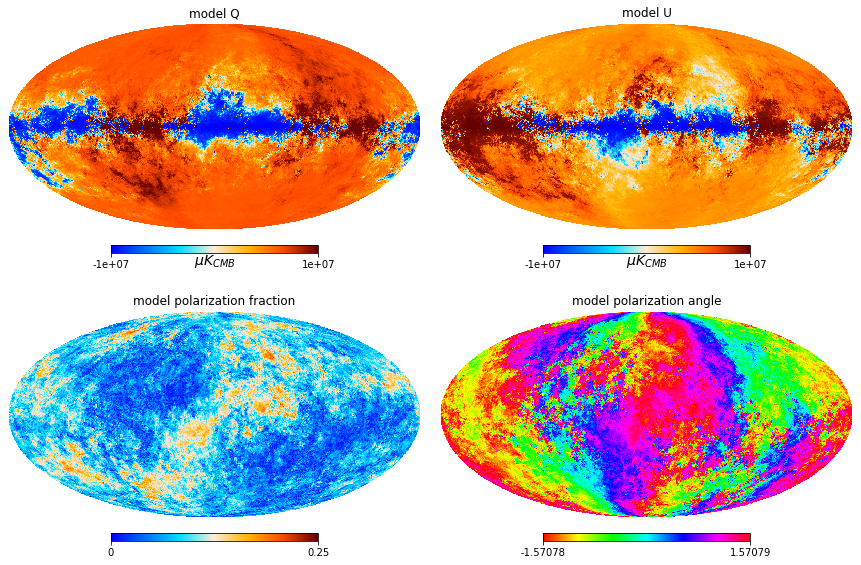

In [174]:
d2r=np.pi/180.

dust_sim=make_dustsim(l0=70*d2r,\
                      b0=24*d2r,\
                      p0=0.25,\
                      alphaM=-2.5,\
                      fM=0.9,\
                      N=7)

pl.figure(figsize=(12,8))

hp.mollview(dust_sim[1],title='model Q', min=-1e7, max=1e7, cmap=cmap, unit=r'$\mu K_{CMB}$', norm='hist', sub=(2,2,1))
hp.mollview(dust_sim[2],title='model U', min=-1e7, max=1e7, cmap=cmap, unit=r'$\mu K_{CMB}$', norm='hist', sub=(2,2,2))
hp.mollview(np.sqrt((dust_sim[1]**2+dust_sim[2]**2)/dust_sim[0]**2), min=0, max=.25, title='model polarization fraction', cmap=cmap, sub=(2,2,3))
hp.mollview(.5*np.arctan2(-dust_sim[2],dust_sim[1]),title='model polarization angle', cmap=pl.cm.hsv, sub=(2,2,4))

## Model Comparison with Real Data: Projection Conventions
Let's compare our model to the real observation of polarized dust emission with the Planck 353 GHz maps. The model is only valid for regions far away from the Galactic plane, hence we will focus only on the observation region of BICEP/Keck. To do so we load the BICEP2 mask, which is given in [celestial coordinates (or equatorial coordinates](https://en.wikipedia.org/wiki/Astronomical_coordinate_systems), and rotate it into Galactic coordinates, in which the Planck maps and thus our model maps are given.

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


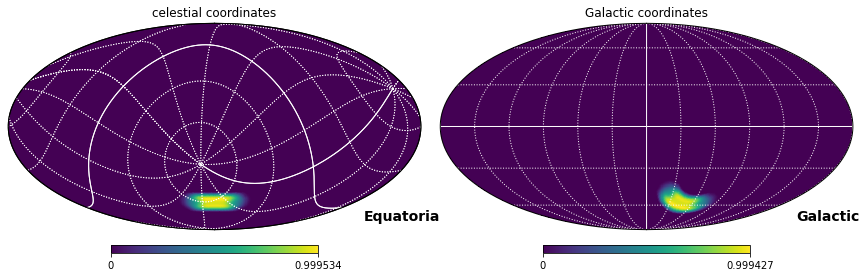

In [66]:
rot = hp.Rotator(coord=['C','G'])

mask=hp.read_map('data/bk14_mask_cel_n0512.fits')
mask=np.nan_to_num(hp.ud_grade(mask,nside))
mask[mask<0]=0

pl.figure(figsize=(12,4))

hp.mollview(mask,sub=(1,2,1),title='celestial coordinates',coord='C')
hp.graticule(coord='G',color='white') # Shows coordinate grid in Galactic coordinates

mask=rot.rotate_map_pixel(mask)

hp.mollview(mask,sub=(1,2,2),title='Galactic coordinates',coord='G')
hp.graticule(coord='G',color='white') # Shows coordinate grid in Galactic coordinates

All previous plots are in galactic coordinates. It is useful to be always prudent which coordinate system the map you are using is in. Sometimes it is not obvious, but a good indicator is the appearance of the Galactic plane in a plot of a full sky map. Try transforming the `dust_map` between Galactic and celestial coordinates. Note that the coordinate grid above shows equal latitute and longitute lines in Galactic coordinates in both cases of the map projection in celestial coordinates (left) and Galactic coordinates (right). In Galactic coordinates the Galactic plane coincides with the equator.

Before we can compare intensity and polarization Q/U maps we have to remember that the reference frequency for out model has $\nu=545\ GHz$, while we only have polarization maps from Planck up to $353\ GHz$. We can use the following short code to produce dust maps at arbitrary frequency using [`PySM`](https://github.com/healpy/pysm) and a choice of dust model (e.g. `d0`, see [here](https://pysm3.readthedocs.io/en/latest/models.html#dust) for more details), in which we replace the template with our dust model.

In [175]:
import pysm.units as u

def freq_scaling(inmap,infreq,outfreq):
    sky = pysm.Sky(nside=nside, preset_strings=["d0"])

    sky.components[0].I_ref = (inmap[0]*u.uK_CMB).to("uK_RJ", equivalencies=u.cmb_equivalencies(infreq*u.GHz))
    sky.components[0].Q_ref = (inmap[1]*u.uK_CMB).to("uK_RJ", equivalencies=u.cmb_equivalencies(infreq*u.GHz))
    sky.components[0].U_ref = (inmap[2]*u.uK_CMB).to("uK_RJ", equivalencies=u.cmb_equivalencies(infreq*u.GHz))
    sky.components[0].freq_ref_I = infreq * u.GHz
    sky.components[0].freq_ref_P = infreq * u.GHz

    outmap = sky.get_emission(outfreq * u.GHz)
    outmap = outmap.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(outfreq*u.GHz))
    outmap = outmap.value
    
    return outmap
    
model_f353_map=freq_scaling(dust_sim,545,353)

/home/users/dobeck/.local/lib/python3.6/site-packages/pysm/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/users/dobeck/.local/lib/python3.6/site-packages/pysm/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/users/dobeck/.local/lib/python3.6/site-packages/pysm/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_u_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")


As a test of the very simple foreground cleaning excercise we did above, we can compare it to the frequency scaling the PySM model is using.

In [169]:
print('The PySM model A^{100 GHz}: %.03f'%(np.mean(freq_scaling(dust_sim,545,100)/freq_scaling(dust_sim,545,353))))

/home/users/dobeck/.local/lib/python3.6/site-packages/pysm/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/users/dobeck/.local/lib/python3.6/site-packages/pysm/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/users/dobeck/.local/lib/python3.6/site-packages/pysm/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_u_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")


The PySM model A^{100 GHz}: 0.020


First we can have a look at the resulting maps of Q, U and the polarization fraction focussed on the BICEP patch. Note that the real data is dominated by noise on smaller scales. Hence we are downgrading the resolution of all maps before we plot them here.

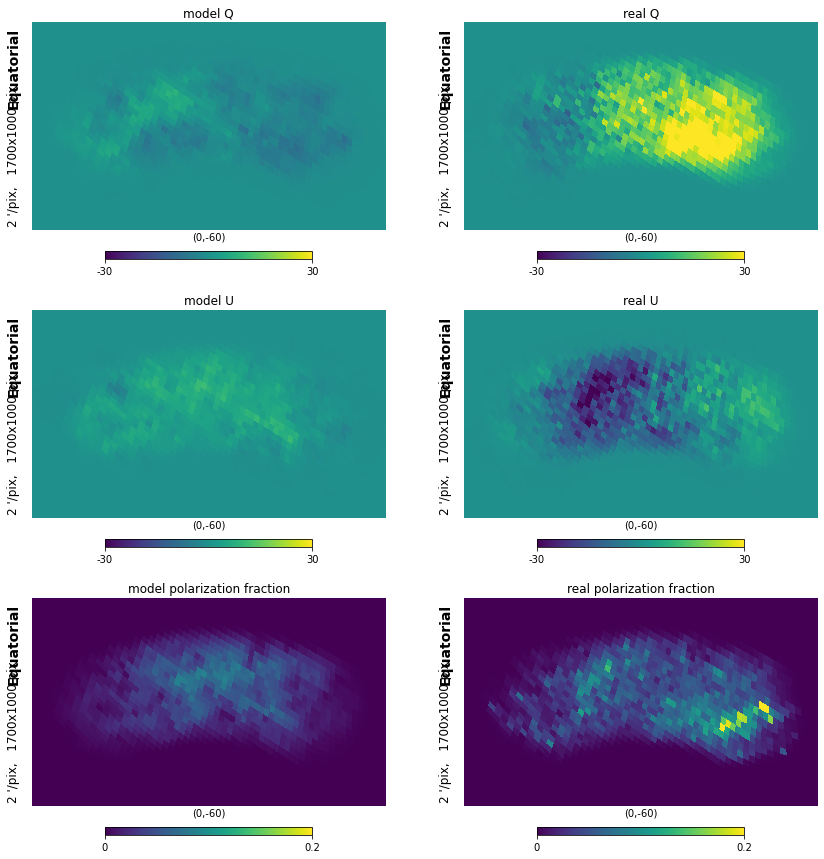

In [202]:
pl.figure(figsize=(12,12))

nside_lr=64

mask_lr=hp.ud_grade(mask,nside_lr)
dust_sim_lr=hp.ud_grade(model_f353_map,nside_lr)
f353_map_lr=hp.ud_grade(f353_map,nside_lr)

hp.gnomview(mask_lr*dust_sim_lr[1],coord='GC',rot=[0,-60],xsize=1700,ysize=1000,reso=2,min=-30,max=30,title='model Q',sub=(3,2,1))
hp.gnomview(mask_lr*f353_map_lr[1],coord='GC',rot=[0,-60],xsize=1700,ysize=1000,reso=2,min=-30,max=30,title='real Q', sub=(3,2,2))

hp.gnomview(mask_lr*dust_sim_lr[2],coord='GC',rot=[0,-60],xsize=1700,ysize=1000,reso=2,min=-30,max=30,title='model U',sub=(3,2,3))
hp.gnomview(mask_lr*f353_map_lr[2],coord='GC',rot=[0,-60],xsize=1700,ysize=1000,reso=2,min=-30,max=30,title='real U', sub=(3,2,4))

hp.gnomview(mask_lr*np.sqrt((dust_sim_lr[1]**2+dust_sim_lr[2]**2)/dust_sim_lr[0]**2),coord='GC',rot=[0,-60],xsize=1700,ysize=1000,reso=2,max=.2,title='model polarization fraction',sub=(3,2,5))
hp.gnomview(mask_lr*np.sqrt((f353_map_lr[1]**2+f353_map_lr[2]**2)/f353_map_lr[0]**2),coord='GC',rot=[0,-60],xsize=1700,ysize=1000,reso=2,max=.2,title='real polarization fraction',sub=(3,2,6))

An important point is that the model attempts to reproduce the "statistical properties" of the Galactic dust emission, not the exact patterns. However, note the variation int he polarization fraction, one property that this model tries to emulate. Hence it's better to look at different metrics to compare this model with real data. First we can have a look at  the histogram of the polarization fraction map above. We compare the distribution of polarization fractions per pixel within the BICEP patch. Try to match them by tuning the model's parameters below.

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


Text(0.5, 0, 'polarization fraction')

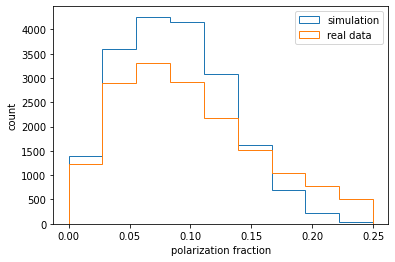

In [201]:
d2r=np.pi/180.

dust_sim=make_dustsim(l0=70*d2r,\
                      b0=24*d2r,\
                      p0=0.25,\
                      alphaM=-2.5,\
                      fM=3.,\
                      N=4)
dust_sim=rot.rotate_map_pixel(dust_sim)

pl.hist((np.sqrt((dust_sim[1]**2+dust_sim[2]**2)/dust_sim[0]**2))[mask!=0],bins=np.linspace(0,.25,10),histtype='step',label='simulation')
pl.hist((np.sqrt((f353_map[1]**2+f353_map[2]**2)/f353_map[0]**2))[mask!=0],bins=np.linspace(0,.25,10),histtype='step',label='real data')
pl.legend()

pl.ylabel('count')
pl.xlabel('polarization fraction')

## Dealing with Noisy Data

Modeling the polarized dust in the regions of the sky we are interested in ("high Galactic latitutes", i.e. far away from the bright Galactic plane) is hard because the signal-to-noise of dust in our data is reatively low. We don't know how the dust looks like at intermediate angular scales to sufficient precision. To make this clear we have to take a look at the noise properties of the best data tracing the Galactic dust emission, the Planck high-frequency maps (in particular the map at 353 GHz).

A common way to distinguish between what's signal and what's noise in our CMB measurements is by comparing two distinct halves of the data. Planck provides several data splits (jackknives in BICEP-speak), for example maps of the first and second half of the mission or two halves of the data using alternating pointing periods (one rotation around the datellite axis). Let's plot the Q and U maps for each half. Common features in the real data maps can be attributed to be signal, differences can be attributed to be noise. Given that the signal is the same in each of the data split, we can use the difference map to estimate statistical properties of the noise.

In [185]:
f353_map_1st=hp.read_map('data/HFI_SkyMap_353_2048_R4.00_full-ringhalf-1.fits',[0,1,2])
f353_map_1st=hp.ud_grade(f353_map_1st,nside)
f353_map_1st*=1e6 # These maps are given in K_{CMB}

f353_map_2nd=hp.read_map('data/HFI_SkyMap_353_2048_R4.00_full-ringhalf-2.fits',[0,1,2])
f353_map_2nd=hp.ud_grade(f353_map_2nd,nside)
f353_map_2nd*=1e6 # These maps are given in K_{CMB}

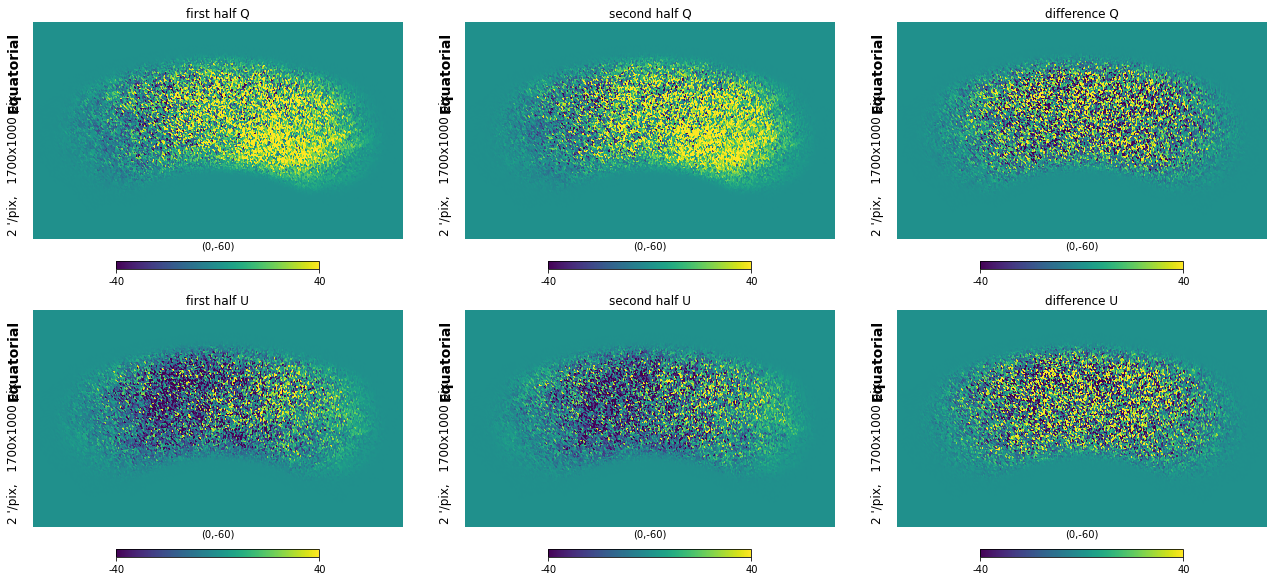

In [189]:
pl.figure(figsize=(18,8))

hp.gnomview(mask*f353_map_1st[1],coord='GC',rot=[0,-60],xsize=1700,ysize=1000,reso=2,min=-40,max=40,title='first half Q',sub=(2,3,1))
hp.gnomview(mask*f353_map_2nd[1],coord='GC',rot=[0,-60],xsize=1700,ysize=1000,reso=2,min=-40,max=40,title='second half Q',sub=(2,3,2))
hp.gnomview(mask*(f353_map_1st[1]-f353_map_2nd[1]),coord='GC',rot=[0,-60],xsize=1700,ysize=1000,reso=2,min=-40,max=40,title='difference Q',sub=(2,3,3))


hp.gnomview(mask*f353_map_1st[2],coord='GC',rot=[0,-60],xsize=1700,ysize=1000,reso=2,min=-40,max=40,title='first half U',sub=(2,3,4))
hp.gnomview(mask*f353_map_2nd[2],coord='GC',rot=[0,-60],xsize=1700,ysize=1000,reso=2,min=-40,max=40,title='second half U',sub=(2,3,5))
hp.gnomview(mask*(f353_map_1st[2]-f353_map_2nd[2]),coord='GC',rot=[0,-60],xsize=1700,ysize=1000,reso=2,min=-40,max=40,title='difference U',sub=(2,3,6))

Using that we can show qualitatively that the map of the polarization fraction is dominated by signal by plotting the polarization fraction of the difference map (i.e. the noise map). Looking at the full real data map we can clearly see features (bright yellow blobs) way stronger than what one would expect from fluctuations from noise shown on the right hand side. We now need a metric to decide that this signal is indeed consistent with our simulated model on the left.

<div class="alert alert-block alert-info">
<b>Exercise:</b> Show in a similar fashion the impact of noise on the histograms of polarization fraction above.
</div>

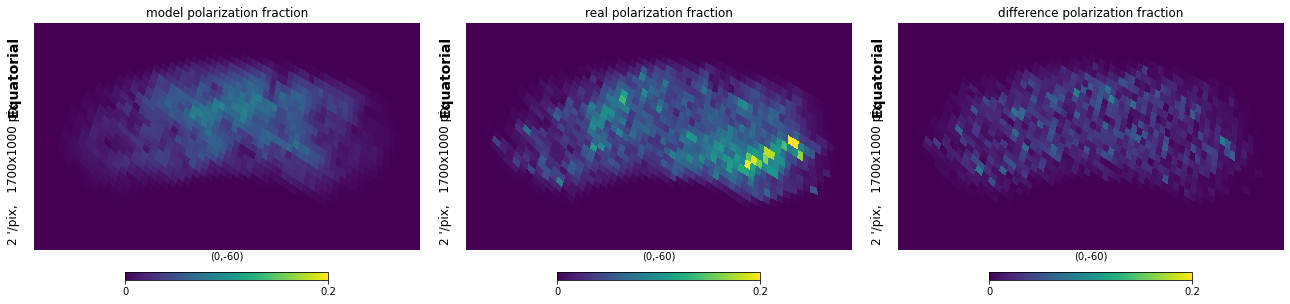

In [194]:
pl.figure(figsize=(18,4))

f353_map_1st_lr=hp.ud_grade(f353_map_1st,nside_lr)
f353_map_2nd_lr=hp.ud_grade(f353_map_2nd,nside_lr)
f353_map_diff_lr=f353_map_1st_lr-f353_map_2nd_lr

hp.gnomview(mask_lr*np.sqrt((dust_sim_lr[1]**2+dust_sim_lr[2]**2)/dust_sim_lr[0]**2),coord='GC',rot=[0,-60],xsize=1700,ysize=1000,reso=2,max=.2,title='model polarization fraction',sub=(1,3,1))
hp.gnomview(mask_lr*np.sqrt((f353_map_lr[1]**2+f353_map_lr[2]**2)/f353_map_lr[0]**2),coord='GC',rot=[0,-60],xsize=1700,ysize=1000,reso=2,max=.2,title='real polarization fraction',sub=(1,3,2))
hp.gnomview(mask_lr*np.sqrt((f353_map_diff_lr[1]**2+f353_map_diff_lr[2]**2)/f353_map_lr[0]**2),coord='GC',rot=[0,-60],xsize=1700,ysize=1000,reso=2,max=.2,title='difference polarization fraction',sub=(1,3,3))

# 4) Power spectra
Considering that the goal is a measurement of the CMB power spectrum it is important to appropriately characterize the impact of foregrounds on such a power spectrum measurement. Note that galactic foregrounds are not statistically isotropic, which means it is not a simple function of the angular multipole $C_\ell$ as in the case of the CMB. Hence the notion of an unbiased estimator of a power spectrum as we introduced it in the previous notebook is not directly applicable here. Nevertheless we can compute a spectrum from foregrounds using the estimator
$$\hat{C}_\ell=\frac{1}{2\ell+1} \sum_m a^*_{\ell m} a_{\ell m},$$
which is a quantity that depends on the actual observed region of the sky and measures the bias of foregrounds on a naive CMB power spectrum estimation.

We can now compute the power spectra of the simulation and the real data. We'll also compute the spectra of the half ring maps as well as the cross-spectrum between them (one $a_{\ell m}$ of the equation above comes from the first half, the other $a_{\ell m}$ from the second half). This cross-spectrum isolutes that part in the input maps that is present in both halves of the data and removes the part that is different between the two (i.e. instrumental noise).

<div class="alert alert-block alert-info">
<b>Exercise:</b> Show that the latter statement is true by split each data half into a part that is the same between halves ($s_{\ell m}$) and a part that is different ($n_{\ell m}$), such that $a^i_{\ell m}=s_{\ell m}+n^i_{\ell m}$.
Extra: Also compute the variance of the estimator $\hat{C}_\ell$ and show that the cross-spectrum has a reduced sensitivity compared to the auto-spectrum of the combination of both halves, $\frac{1}{2}(a_{\ell m}^1+a_{\ell m}^2)$. 
</div>

In [203]:
lmax=500

fsky=(np.mean(mask**2))

cl_real=hp.anafast(mask*f353_map,lmax=lmax)/fsky
cl_sim =hp.anafast(mask*model_f353_map,lmax=lmax)/fsky

cl_1st=hp.anafast(mask*f353_map_1st,lmax=lmax)/fsky
cl_2nd=hp.anafast(mask*f353_map_2nd,lmax=lmax)/fsky
cl_cross=hp.anafast(mask*f353_map_1st,map2=mask*f353_map_2nd,lmax=lmax)/fsky

And now some plots. I'm plotting the spectra, $C_\ell$, a prefactor $\ell(\ell+1)/2\pi$, which had/has the purpose to display CMB spectra as relatively flat curves.

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in power


(2, 2000)

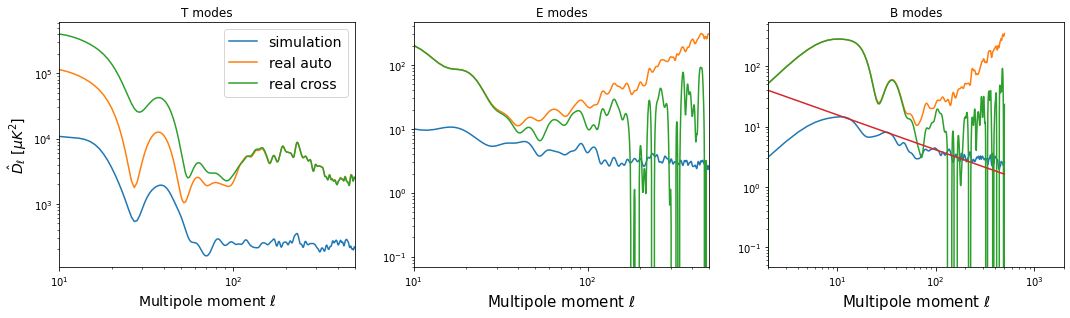

In [204]:
l=np.arange(lmax+1)

pl.figure(figsize=(18,4.5))
ax=pl.subplot(1,3,1)

ax.plot(l,l*(l+1)/2/np.pi*cl_sim[0],label='simulation')
ax.plot(l,l*(l+1)/2/np.pi*cl_real[0],label='real auto')
ax.plot(l,l*(l+1)/2/np.pi*cl_cross[0],label='real cross')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('T modes')
ax.set_xlabel('Multipole moment $\ell$',fontsize=14)
ax.set_ylabel('$\hat{D}_{\ell}$ $[\mu K^2]$',fontsize=14)
ax.set_xlim(10,500)
pl.legend(fontsize=14)

ax=pl.subplot(1,3,2)

ax.plot(l,l*(l+1)/2/np.pi*cl_sim[1],label='simulation')
ax.plot(l,l*(l+1)/2/np.pi*cl_real[1],label='real auto')
ax.plot(l,l*(l+1)/2/np.pi*cl_cross[1],label='real cross')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('E modes')
ax.set_xlabel('Multipole moment $\ell$',fontsize=15)
ax.set_xlim(10,500)

ax=pl.subplot(1,3,3)

ax.plot(l,l*(l+1)/2/np.pi*cl_sim[2],label='simulation')
ax.plot(l,l*(l+1)/2/np.pi*cl_real[2],label='real auto')
ax.plot(l,l*(l+1)/2/np.pi*cl_cross[2],label='real cross')
pl.loglog(ell,4.7*(l/80)**(-0.58))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('B modes')
ax.set_xlabel('Multipole moment $\ell$',fontsize=15)
ax.set_xlim(2,2000)

You can see that the power spectra match very well when we consider the cross spectra of the real data. This is because the noise, which is primarily responsible for the excess at higher multipoles in the orange line, does not correlate between the two halves. Hence, we are sure that the green line represents the signal. It has to be checked if the difference in the intensity spectrum is due to the CMB in the real data or not. You can also see the power-law spectrum for B-modes, which coincides with the best-fit model of the latest BICEP/Keck release.

Let's now summarize the simulation process in one function and contrast the model introduced here with a simple dust model, commonly called Gaussian dust. We simulate it as a random Gaussian realization of a power-law power spectrum as introduced in the previous plot.

In [206]:
def make_nongaussian_sim(l0=70,b0=24,p0=0.26,alphaM=-2.5,fM=0.9,N=7,Nsims=30):
    dust_sim=make_dustsim(l0=l0*d2r,b0=b0*d2r,p0=p0,alphaM=alphaM,fM=fM,N=N)
    dust_sim=freq_scaling(dust_sim,545,353)

    return dust_sim

def make_gaussian_sim(Adust=4.7,alpha=-0.58,EtoB=2,TtoE=10):
    l=np.arange(3*nside-1)

    dl=Adust*(l/80)**alpha
    cl=dl*2*np.pi/l/(l+1.)
    cl[:2]=0
    
    cl=np.array([cl*EtoB*TtoE,cl*EtoB,cl,cl*0])

    return hp.synfast(cl,nside,new=True)

We can now use what we leraned in the previous notebook and compute binned power spectra of a bunch of simulations for each type.

In [215]:
g_sim_maps=np.zeros((20,3,hp.nside2npix(nside)))
ng_sim_maps=np.zeros((20,3,hp.nside2npix(nside)))

for i in range(len(ng_sim_maps)):
    g_sim_maps[i]=make_gaussian_sim()
    ng_sim_maps[i]=make_nongaussian_sim()

cl_gaussian=np.array([hp.anafast(m*mask,lmax=lmax)/fsky for m in g_sim_maps])
cl_nongaussian=np.array([hp.anafast(m*mask,lmax=lmax)/fsky for m in ng_sim_maps])

bins=np.arange(20,700,35)
b=.5*(bins[1:]+bins[:-1])

def bin_spectra(cl):
    cb=np.zeros((*np.shape(cl)[:-1],len(bins)-1))
    for i in range(len(bins)-1):
        cb[...,i]=np.mean(cl[...,bins[i]:bins[i+1]],axis=-1)
    return cb

cb_gaussian=bin_spectra(l*(l+1)/2/np.pi*cl_gaussian)
cb_nongaussian=bin_spectra(l*(l+1)/2/np.pi*cl_nongaussian)

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in power
  # Remove the CWD from sys.path while we load stuff.
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':
/home/users/dobeck/.local/lib/python3.6/site-packages/pysm/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/users/dobeck/.local/lib/python3.6/site-packages/pysm/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/users/dobeck/.local/lib/python3.6/site-packages/pysm/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_u_new.fits (if not cached already)
  w

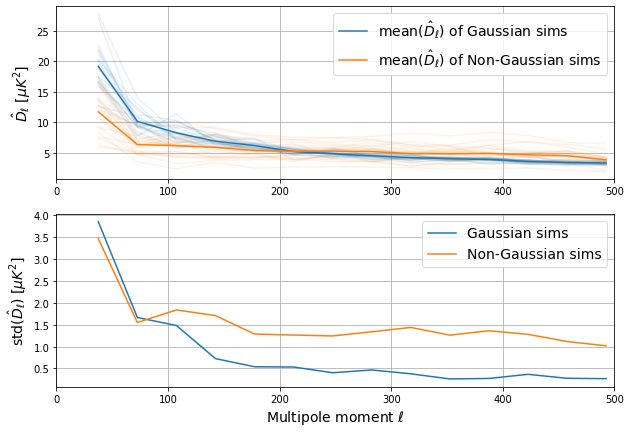

In [219]:
pl.figure(figsize=(10,7))

field=1

ax=pl.subplot(2,1,1)

for c in cb_gaussian:
    ax.plot(b,c[field,:],c='C0',alpha=.1)
for c in cb_nongaussian:
    ax.plot(b,c[field,:],c='C1',alpha=.1)
ax.plot(b,np.mean(cb_gaussian[:,field,:],axis=0),c='C0',label='mean$(\hat{D}_{\ell})$ of Gaussian sims')
ax.plot(b,np.mean(cb_nongaussian[:,field,:],axis=0),c='C1',label='mean$(\hat{D}_{\ell})$ of Non-Gaussian sims')

ax.set_ylabel('$\hat{D}_{\ell}$ $[\mu K^2]$',fontsize=14)
ax.grid()
ax.set_xlim(0,500)
ax.legend(fontsize=14)


ax=pl.subplot(2,1,2)

ax.plot(b,np.std(cb_gaussian[:,field,:],axis=0),c='C0',label='Gaussian sims')
ax.plot(b,np.std(cb_nongaussian[:,field,:],axis=0),c='C1',label='Non-Gaussian sims')

ax.set_xlabel('Multipole moment $\ell$',fontsize=14)
ax.set_ylabel('std$(\hat{D}_{\ell})$ $[\mu K^2]$',fontsize=14)
ax.grid()
ax.set_xlim(0,500)
ax.legend(fontsize=14)

Ideally we would like to make the mean of Non-Gaussian sims coincide with the mean of Gaussian sims, given the latter is constrained by BICEP/Keck data.